In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import HTML
import gym
from gym import wrappers
import io
import base64

**State observation**:
    
    Type: Box(4)

    Num     Observation               Min                     Max
    0       Cart Position             -4.8                    4.8
    1       Cart Velocity             -Inf                    Inf
    2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
    3       Pole Angular Velocity     -Inf                    Inf

- For this project, I will describe the state of the pendulum using only the angle and angular velocity of the pole, ignoring the position and the velocity of cart.

**Actions**:

    Type: Discrete(2)
    
    Num   Action
    0     Push cart to the left
    1     Push cart to the right

In [3]:
env = gym.make('CartPole-v0')
env.reset()

print("Number of actions: " + str(env.action_space.n))
print("Observation space: " + str(env.observation_space))
print("Max. values of observation space:" + str(env.observation_space.high))
print("Min. values of observation space:" + str(env.observation_space.low))

Number of actions: 2
Observation space: Box(4,)
Max. values of observation space:[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Min. values of observation space:[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


In [53]:
# helper functions

def state_filter(state):
    """ only use the angle and the angular velocity of the pole to describe the state"""
    
    return state[[2,3]]


def random_action(state):
    """ return a random action: either 0 (left) or 1 (right)"""
    
    action = env.action_space.sample()  
    return action

I generate random samples $S$ in this setting by simulating a uniform random number (max 100) of uniform random actions from the initial state. If the pendulum fell within this sequence, the procedure was repeated.

In [2]:
def generate_init_states_S():
    """this function returns a list of randomly generated initial states from the CartPole-v0 environment """
    
    n_actions = np.random.randint(low=1, high=101)                   # how many actions to generate
    seq_actions = np.random.randint(low=0,high=2,size=n_actions)  # random sequence of actions

    init_states_S = []   # to store initial states

    env = gym.make('CartPole-v0')
    env.reset()
    env.action_space.seed(16)

    for action in seq_actions:

        state, reward, done, info = env.step(action)  # implement the actions in the random sequence
        init_states_S.append(state)                   # append the environment state to list (here, I store all 4 state observations: not only angular velocity and angle)

        if done: # the episode ends either if the pole is > 15 deg from vertical or the cart move by > 2.4 unit from the centre
            env.reset()    
            
    env.close()
            
    return init_states_S

 Generate a sequence of intial states (for $S$) and display first 10

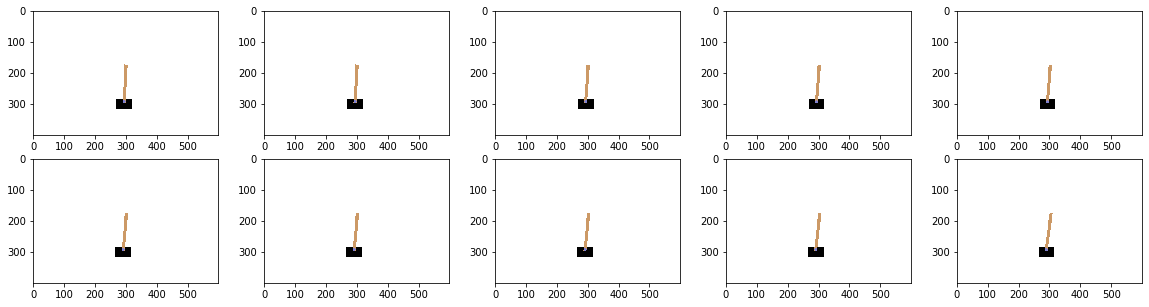

In [3]:
init_states_S = generate_init_states_S() # randomly generated states initial

env = gym.make('CartPole-v0') # create inv. pend environment
env = env.unwrapped           # unwrap the environment to send custom initial states

fig = plt.figure(figsize=(20,5))

for i in range(10):
    env.state = init_states_S[i]
    fig.add_subplot(2,5,i+1)
    plt.imshow(env.render(mode="rgb_array"))
    env.close()
    
plt.show()

I partition the action space to create multiple actions, because in these cases it becomes less and less likely that a unique best actions can be found. The range of the original action set {−1, 0, 1} is partitioned equidistantly into the given number of actions:

In [38]:
def partition_action_space(env,n_actions):
    """this function partitions the action space of a given environment into a given number of `n_actions`"""
    
    actions = np.arange(env.action_space.n)

    # a uniform noise term is added to action signals to make all state transitions non-deterministic
    part_act_space = np.linspace(actions[0],actions[-1],n_actions) + np.random.uniform(low = -.2,high=.2) 
    
    return part_act_space                                                                                

In [39]:
env = gym.make('CartPole-v0')

print("Original action space: " + str(env.action_space.n))
print("Partitioned into 3 actions: " + str(partition_action_space(env,3)))
print("Partitioned into 9 actions: " + str(partition_action_space(env,9)))
print("Partitioned into 17 actions: " + str(partition_action_space(env,17)))

Original action space: 2
Partitioned into 3 actions: [0.04021888 0.54021888 1.04021888]
Partitioned into 9 actions: [0.15050533 0.27550533 0.40050533 0.52550533 0.65050533 0.77550533
 0.90050533 1.02550533 1.15050533]
Partitioned into 17 actions: [-0.11991534 -0.05741534  0.00508466  0.06758466  0.13008466  0.19258466
  0.25508466  0.31758466  0.38008466  0.44258466  0.50508466  0.56758466
  0.63008466  0.69258466  0.75508466  0.81758466  0.88008466]


### Preference-based Approximate Policy Iteration algorithm

In [121]:
#####################################
### Evaluate-Preference procedure ###

### Description:
###  This is done using roll-outs
###  At every state in the initial state set, roll-outs are generated from each action for the same policy
###  Accumulated rewards from each roll-out from each action are used to generate preferences for every pair of actions
###  Generated preferences are stored in the training set; training data are used to learn the LabelRanker

### Functionality:
### - INPUTS  : starting state (s), two-actions(a_k, a_j), (current) policy (\pi), max. length of trajectoris (L)
### - PROCESS : generate roll-out (fixed time horizon) and calculate accumulate reward
### - OUTPUT  : compare return from each rollout: store preference info in training dataset as (s,a_k > a_j)

### - Run this procedure for every action-pair at all initial-states

def evaluate_preference(starting_state
                        , action_1
                        , action_2
                        , policy
                        , environment_name = 'CartPole-v0'
                        , discount_fac = 0.99
                        , n_rollouts = 10
                        , max_rollout_len = 10
                       ):
    
    policy = policy              # policy to follow in roll-outs
    n_rollouts = n_rollouts      # number of roll-outs to generate
    s_init = starting_state      # starting state
    gamma = discount_fac         # discount factor

    # dict. to store actions
    actions = { 'one' : action_1 
              , 'two' : action_2}    

    # dict to store  rewards of roll-outs starting from each action
    r = { 'one' : [None]*n_rollouts 
        , 'two' : [None]*n_rollouts}  

    # dict to store average discounted return for for each action
    avg_r = {}  

    max_traj_len = max_rollout_len # maximum roll-out trajectory length

    for action_key, action_value in actions.items():

        # generate roll-outs
        for rollout in range(n_rollouts):

            env = gym.make(environment_name)
            env = env.unwrapped

            env.state = s_init  # set the starting state

            # perform action action value is rounded to discretize
            observation, reward, done, info = env.step(round(action_value)) 

            r[action_key][rollout] = reward # add the immediate reward of the action

            traj_len = 1
            while traj_len < max_traj_len and not done:

                observation, reward, done, info = env.step(policy(observation)) ### NEED TO DEFINE A POLICY

                r[action_key][rollout] += (gamma**traj_len) * reward

                traj_len += 1

            env.reset()
            env.close()

        # calculate average discounted return 
        avg_r[action_key]  = sum(r[action_key]) / len(r[action_key])

    # return preference info. to generate training data
    if avg_r['one'] > avg_r['two']:
        return {'state': s_init
               , 'a_k_prefered_a_j' : [actions['one'],actions['two']]
               , 'preference_label' : 1}
    elif avg_r['two'] > avg_r['one']:
        return {'state': s_init
               , 'a_k_prefered_a_j' : [actions['two'],actions['one']]
               , 'preference_label' : 1}
    else:
        return None

In [132]:
evaluate_preference(env.reset(),0.51,0,random_action)

{'state': array([ 0.00564924,  0.01084504, -0.00988976, -0.01124729]),
 'a_k_prefered_a_j': [0, 0.51],
 'preference_label': 1}

In [120]:
round(0.51)

1

In [ ]:
### Label Ranker ###



In [ ]:
### INITIALIZATION ###

# sample states
# initial (random) policy
# max. number of policy iterations
# EvaluatePreference procedure

## APPENDIX

### Visualize episode

In [12]:
env = gym.make('CartPole-v0')
env = wrappers.Monitor(env, "./gym-results", force=True)
env.reset()
for _ in range(1000):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done: break
env.close()

video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

episode 19 finished after 8 timesteps. Total reward: 8.0


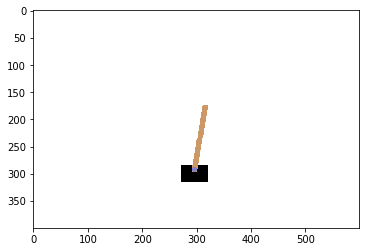

In [5]:
nb_episodes = 20
nb_timesteps = 100
img = plt.imshow(env.render(mode='rgb_array')) # only call this once

for episode in range(nb_episodes):  # iterate over the episodes
    state = env.reset()             # initialise the environment
    rewards = []
    
    for t in range(nb_timesteps):    # iterate over time steps
        #env.render()                 # display the environment
        img.set_data(env.render(mode='rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, info = env.step(0)  # implement the action chosen by the policy
        rewards.append(reward)      # add 1 to the rewards list
        
        if done: # the episode ends either if the pole is > 15 deg from vertical or the cart move by > 2.4 unit from the centre
            cumulative_reward = sum(rewards)
            print("episode {} finished after {} timesteps. Total reward: {}".format(episode, t+1, cumulative_reward))  
            break
    
env.close()